/tmp/ipykernel_47532/218229293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__i

Train - R2:	0.987
Train - MAE:	0.086
Train - RMSE:	0.116
Train - Adjusted R2:	0.987

Test - R2:	0.968
Test - MAE:	0.164
Test - RMSE:	0.273
Test - Adjusted R2:	0.967


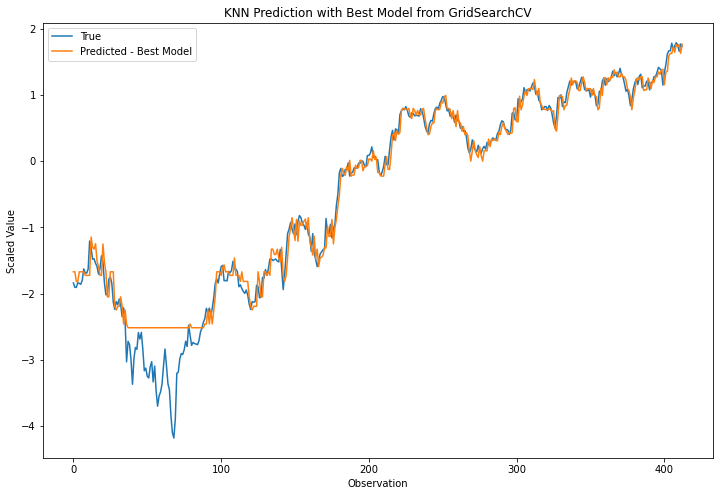

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Loading dataset
exchange_data = pd.read_csv('GBPUSD.csv')
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

# Sorting data in ascending order
data_frame = ind_exchange_data.sort_index(axis=1, ascending=True)
data_frame = data_frame.iloc[::-1]
df = data_frame[["close"]]

# Splitting data into train and test sets
split_date = pd.Timestamp('06-01-2021')
train = df.loc[split_date:]
test = df.loc[:split_date]

# Standardizing data
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = train_sc[:-1]
y_train = train_sc[1:].ravel()

X_test = test_sc[:-1]
y_test = test_sc[1:].ravel() 

# Training Model
param_grid = {
    'pca__n_components': range(1, X_train.shape[1] + 1),
    'knn__n_neighbors': range(1, 31),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

pipeline = Pipeline([
    ('pca', PCA()),  # Dimensionality reduction
    ('knn', KNeighborsRegressor())  # KNN model
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


y_pred_test = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

# Calculating evaluation metrics
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("Train - R2:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("Train - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("Train - RMSE:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("Train - Adjusted R2:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))

print("Test - R2:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("Test - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("Test - RMSE:\t{:0.3f}".format(rmse_test))
print("Test - Adjusted R2:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

# Plotting true vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='Predicted - Best Model')
plt.title("KNN Prediction with Best Model from GridSearchCV")
plt.xlabel('Observation')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()